# Detecting Melanoma with a Convolutional Neural Network

In this mini project, I will design an algorithm that can visually diagnose [melanoma](https://www.skincancer.org/skin-cancer-information/melanoma), the deadliest form of skin cancer. In particular, the algorithm will distinguish this malignant skin tumor from two types of benign lesions ([nevis](http://missinglink.ucsf.edu/lm/dermatologyglossary/nevus.html)  and [seborrheic keratoses](https://www.aad.org/public/diseases/bumps-and-growths/seborrheic-keratoses)).

![](https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a18789d_skin-disease-classes/skin-disease-classes.png)

### Table of Contents

1. Load Images and Data Augmentation
2. Create Model
3. Train Model
4. Test Model
5. Submission
6. Conclussion

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import matplotlib.pyplot as plt
import seaborn as sns # Plotting library
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.utils import np_utils
from sklearn.datasets import load_files   
from tqdm import tqdm
from collections import Counter


print(os.listdir("../input"))

Using TensorFlow backend.


['udacitydermatologistai', 'skin-lesion-analysis-towards-melanoma-detection']


There are a lot more samples of nevus compared to the other two. This might cause the network to be biased. It will try to maximize the error function, and by classifying everything as nevus it will accomplish that.

For this problem we will need to be careful with the accuracy metric. I will try to balance the data in the model.

# 1. Load the data


In [2]:
data_train_path = '../input/skin-lesion-analysis-towards-melanoma-detection/train/train'
data_valid_path = '../input/skin-lesion-analysis-towards-melanoma-detection/valid/valid'
data_test_path = '../input/skin-lesion-analysis-towards-melanoma-detection/test/test'

**EDA**

Lets find out how many samples we have for each category.

In [3]:
# define function to load train, test, and validation datasets
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_train_path)

<BarContainer object of 3 artists>

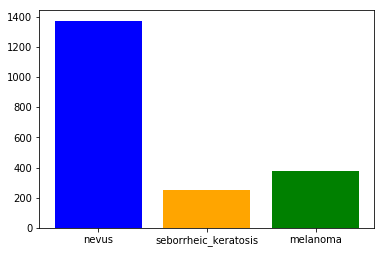

In [4]:
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

**Upsampling function for imbalanced data**

Using scikit learn's resample function I will create new samples of the under-represented data.

In [5]:
def plot_n_samples(filenames):
    filenames_trimmed = [filename.split('/')[-2] for filename in filenames]
    classes_count = Counter(filenames_trimmed)

    # Plot the classes
    plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

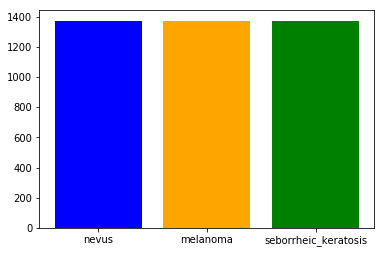

In [6]:
from sklearn.utils import resample, shuffle

# Choose one of the 3 for the feature_name
feature_names = {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}

def upsample(filenames, targets, feature_name, n_samples = 1372):
    upsample_idx = []
    

    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if feature_name in path.split('/'):
            upsample_idx.append(i)
    
    # Remove selected features from filenames to add the upsampled after
    new_filenames = [filename for i, filename in enumerate(filenames) if i not in upsample_idx]
    new_targets = [target for i, target in enumerate(targets) if i not in upsample_idx]

    # Upsample
    resampled_x, resampled_y = resample(filenames[upsample_idx], targets[upsample_idx], n_samples=n_samples, random_state=0)

    # Add the upsampled features to new_filenames and new_targets
    new_filenames += list(resampled_x)
    new_targets += list(resampled_y) 
    
    return np.array(new_filenames), np.array(new_targets)
    
# We upsample twice: once for each feature we want upsampled
upsample_train_x, upsample_train_y = upsample(train_filenames, train_targets, feature_names[0])
upsample_train_x, upsample_train_y = upsample(upsample_train_x, upsample_train_y, feature_names[2])

plot_n_samples(upsample_train_x)

**Downsampling function for imbalanced data**

In [7]:
'''
# Use only if not using the up-sampling function
def downsample(filenames, targets, n_samples = 370):
    nevus_idx = []
    
    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If nevus, save the index
        if 'nevus' in path.split('/'):
            nevus_idx.append(i)
    
    nevus_idx = np.sort(shuffle(nevus_idx)[n_samples:]) # shuffle indices

    # Downsample
    new_filenames = [filename for i, filename in enumerate(filenames) if i not in nevus_idx]
    new_targets = [target for i, target in enumerate(targets) if i not in nevus_idx]
    
    
    return new_filenames, new_targets
            
downsample_train_x, downsample_train_y = downsample(train_filenames, train_targets)

plot_n_samples(downsample_train_x)
'''

"\n# Use only if not using the up-sampling function\ndef downsample(filenames, targets, n_samples = 370):\n    nevus_idx = []\n    \n    # Find all the indices for nevus\n    for i, path in enumerate(filenames):\n        # If nevus, save the index\n        if 'nevus' in path.split('/'):\n            nevus_idx.append(i)\n    \n    nevus_idx = np.sort(shuffle(nevus_idx)[n_samples:]) # shuffle indices\n\n    # Downsample\n    new_filenames = [filename for i, filename in enumerate(filenames) if i not in nevus_idx]\n    new_targets = [target for i, target in enumerate(targets) if i not in nevus_idx]\n    \n    \n    return new_filenames, new_targets\n            \ndownsample_train_x, downsample_train_y = downsample(train_filenames, train_targets)\n\nplot_n_samples(downsample_train_x)\n"

In [8]:
from keras.preprocessing import image   

# Convert the image paths to tensors Manually
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224,224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


train_filenames = paths_to_tensor(upsample_train_x)
train_targets = upsample_train_y

100%|██████████| 4116/4116 [11:55<00:00,  5.00it/s]


**Load the data**

In [9]:
batch_size=60

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [10]:
# Generators
'''
train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
'''

train_generator = datagen_train.flow(train_filenames, train_targets, batch_size=batch_size)

valid_generator = datagen_valid.flow_from_directory(
        data_valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = datagen_test.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [11]:
num_train = len(train_filenames)
num_valid = len(valid_generator.filenames)
num_test = len(test_generator.filenames)

print(num_train, num_valid, num_test)

4116 150 600


Get the class indices

To get the label we find the index of the 1 in the one hot encoded vector which should match the index in a dictionary. Eg:
* label = `[1,0,0]` ---> class_index = `0`
* label = `[0,1,0]` ---> class_index = `1`
* label = `[0,0,1]` ---> class_index = `2`

In [12]:
# Class name to the index
#class_2_indices = train_generator.class_indices
class_2_indices = {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
print("Class to index:", class_2_indices)

# Reverse dict with the class index to the class name
indices_2_class = {v: k for k, v in class_2_indices.items()}
print("Index to class:", indices_2_class)

Class to index: {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
Index to class: {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratoses'}


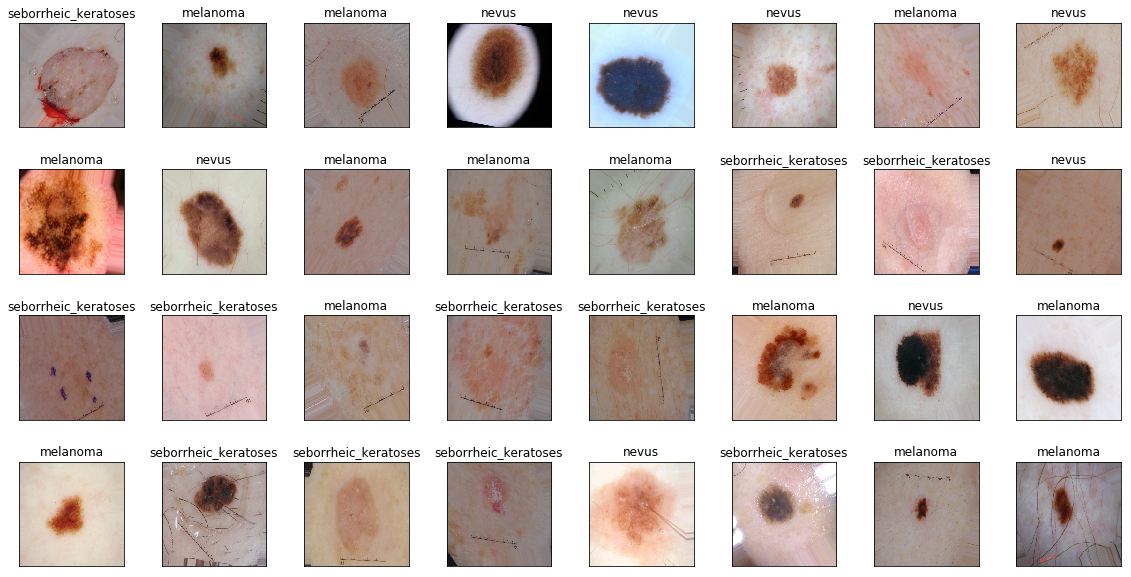

In [13]:
# Lets have a look at some of our images
images, labels = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])
    ax.set(title=indices_2_class[image_idx])

# 2. Create the model

**Log**

```
> Used VGG19 pre-trained (frozen layers) with 2 fully connected layers and got no improvement over 50%.

> Used InceptionV3 pre-trained (frozen layers) with 2 fully connected layers and got no improvement over 50%.

> Used InceptionV3 pre-trained, (de-frosted layers lol) and with 3 fully connected layers and got no improvement over 50%.

> Used ResNet50 ... same.

> Changed Flatten layer to GlobalAveragePooling and it seems to perform better.

> Added class_weights to help balance the classes.

> Downsampled the data with the most occurrences (nevus). I am not getting everything predicted as nevus anymore, but I still get low ROC AUC scores (even below 0.5, which would actually kill people!!!).

> ResNet50 with 1 hidden layer and 0.95 Dropout. Accuracy has improved slightly to ~ 0.65. RocAuc scores still bad.

> Keras .flow's property shuffle was set to True by default. Changed it as it was the cause for getting such horrible ROC AUC scores. Now the Auc Scores look a lot better.

> Tried oversampling by repeating some of the downsampled images. Results improved. Better results than performing undersampling.
```

**Define the model architecture**

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback

base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = MaxAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='elu')(x)
x = Dropout(0.95)(x)
# and a logistic layer
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

#model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


**Trying out a custom made model for debugging**

In [15]:
'''
model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same',
                  input_shape=(224,224,3), kernel_initializer='he_normal'))

model.add(Conv2D(32, (3,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64, (3,3)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(256, (3,3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(500))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(BatchNormalization())
model.add(Activation('softmax'))

          
model.summary()
'''

"\nmodel = Sequential()\n\n### TODO: Define your architecture.\nmodel.add(Conv2D(filters=16, kernel_size=2, padding='same',\n                  input_shape=(224,224,3), kernel_initializer='he_normal'))\n\nmodel.add(Conv2D(32, (3,3)))\nmodel.add(MaxPooling2D(pool_size=2))\nmodel.add(Conv2D(64, (3,3)))\nmodel.add(Conv2D(128, (3,3)))\nmodel.add(MaxPooling2D(pool_size=2))\nmodel.add(Conv2D(256, (3,3)))\nmodel.add(MaxPooling2D(pool_size=2))\n\nmodel.add(Flatten())\nmodel.add(Dense(1000))\nmodel.add(Activation('elu'))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.5))\nmodel.add(Dense(500))\nmodel.add(Activation('elu'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(3))\nmodel.add(BatchNormalization())\nmodel.add(Activation('softmax'))\n\n          \nmodel.summary()\n"

**Compile the model**

In [16]:
from keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

# 3.Train the model

**Assign weights to imbalanced classes**

The dataset shows an imbalance. By assigning bigger weights to the misrepresented classes in the dataset we will help to correct this issue.

In [17]:
from sklearn.utils import class_weight

# Convert one hot encoded labels to ints
train_targets_classes = [np.argmax(label) for label in train_targets]

# Compute the weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_targets_classes),
                                                  train_targets_classes)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 1.0, 1: 1.0, 2: 1.0}


**Train the model**

In [18]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

history = model.fit_generator(train_generator,
                    class_weight= class_weights_dict,
                    steps_per_epoch=num_train//batch_size,
                    epochs=40,
                    verbose=0,
                    callbacks=[checkpointer, scheduler, TQDMNotebookCallback(), early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

Instructions for updating:
Use tf.cast instead.



Epoch 00001: val_loss improved from inf to 0.88351, saving model to aug_model.weights.best.hdf5



Epoch 00002: val_loss improved from 0.88351 to 0.70317, saving model to aug_model.weights.best.hdf5



Epoch 00003: val_loss did not improve from 0.70317



Epoch 00004: val_loss did not improve from 0.70317



Epoch 00005: val_loss improved from 0.70317 to 0.52680, saving model to aug_model.weights.best.hdf5



Epoch 00006: val_loss improved from 0.52680 to 0.49498, saving model to aug_model.weights.best.hdf5



Epoch 00007: val_loss did not improve from 0.49498



Epoch 00008: val_loss did not improve from 0.49498



Epoch 00009: val_loss did not improve from 0.49498



Epoch 00010: val_loss did not improve from 0.49498



Epoch 00011: val_loss did not improve from 0.49498

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.



Epoch 00012: val_loss did not improve from 0.49498



Epoch 00013: val_loss did not improve from 0.49498



Epoch 00014: val_loss did not improve from 0.49498



Epoch 00015: val_loss did not improve from 0.49498



Epoch 00016: val_loss did not improve from 0.49498

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.



# 4. Test model

**Load the model with the best Validation Accuracy**

In [19]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.weights.best.hdf5')

In [20]:
score = model.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

600/600 [==============================] - 274s 457ms/step

 Test accuracy: 0.7333333333333333


**Predictions for the test data**

* `task_1`: the model's predicted probability that the image depicts **melanoma**
* `task_2`: the model's predicted probability that the image depicts **seborrheic keratosis**

In [21]:
predictions = model.predict_generator(test_generator, steps=num_test)

task_1 = pd.DataFrame(data=[desease[0] for desease in predictions])
task_2 = pd.DataFrame(data=[desease[2] for desease in predictions])

**RocAuc Score**

In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score

ground_truth = pd.read_csv("../input/udacitydermatologistai/repository/udacity-dermatologist-ai-2ec0ca9/ground_truth.csv")
labels = np_utils.to_categorical(np.array(test_generator.classes), 3)

roc_auc_all = roc_auc_score(labels, predictions)
roc_auc_task_1 = roc_auc_score(ground_truth['task_1'], task_1)
roc_auc_task_2 = roc_auc_score(ground_truth['task_2'], task_2)

print('Roc auc score for all data is: {}'.format(roc_auc_all))
print('Roc auc score for task 1 is: {}'.format(roc_auc_task_1))
print('Roc auc score for task 2 is: {}'.format(roc_auc_task_2))

Roc auc score for all data is: 0.8210149782787308
Roc auc score for task 1 is: 0.7451823538780061
Roc auc score for task 2 is: 0.9194335511982571


**Lets visualize some of our predictions**

In [23]:
test_filenames, test_targets = load_data_raw(data_test_path)

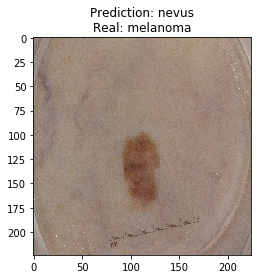

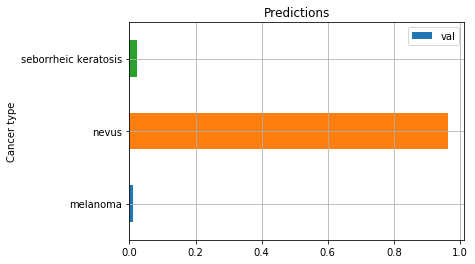

In [24]:
def plot_prediction(img_file, img_target):

    img = image.load_img(img_file, target_size=(224,224))
    img = image.img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    
    # Make a prediction
    prediction = model.predict(img_expand, steps=1)
    image_idx = np.argmax(prediction[0])
    prediction_string = indices_2_class[image_idx]
    
    # Get the real label's name
    label_idx = np.argmax(img_target)
    real_label = indices_2_class[label_idx]
    
    # Plot predictions
    title = "Prediction: {}\nReal: {}".format(prediction_string, real_label)
    
    plt.imshow(img)
    plt.title(title)
    
    pred_df = pd.DataFrame({'Cancer type':['melanoma', 'nevus', 'seborrheic keratosis'], 'val':prediction[0]})
    ax = pred_df.plot.barh(x='Cancer type', y='val', title="Predictions", grid=True)
    
random_index = np.random.randint(0, len(test_generator.filenames))
plot_prediction(test_filenames[random_index], test_targets[random_index])

**Performance curves**

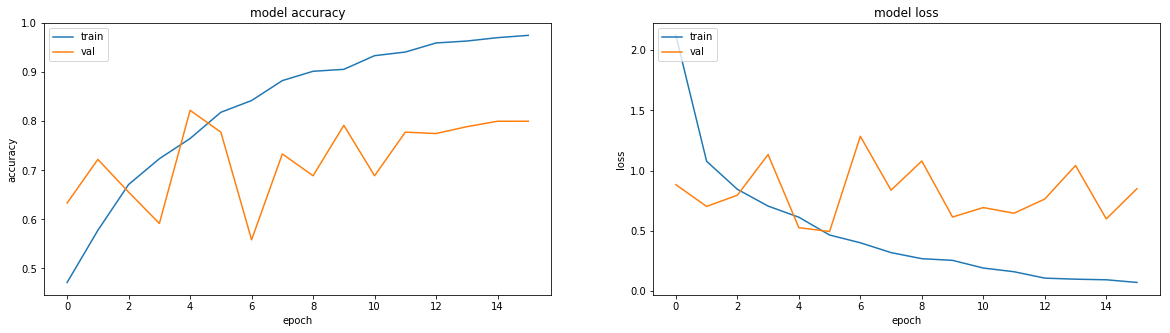

In [25]:
plts, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

# summarize history for accuracy
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'val'], loc='upper left')

# 5. Submission

In [26]:
# submission
submission = pd.read_csv("../input/udacitydermatologistai/repository/udacity-dermatologist-ai-2ec0ca9/sample_predictions.csv")
submission['task_1'] = task_1
submission['task_2'] = task_2
submission.to_csv("submission_dermatologist.csv", index=False)
display(submission.head())

,Id,task_1,task_2
0,data/test/melanoma/ISIC_0012258.jpg,0.161992,0.636583
1,data/test/melanoma/ISIC_0012356.jpg,0.367095,0.219302
2,data/test/melanoma/ISIC_0012369.jpg,0.179478,0.391857
3,data/test/melanoma/ISIC_0012395.jpg,0.139450,0.258832
4,data/test/melanoma/ISIC_0012425.jpg,0.921833,0.001792


# 6. Conclussion

Due to the nature of the problem, it is very important that we make no mistake when identifying a patient as _not sick_. We prefer to send someone who is not sick for more tests, rather than someone who is sick home. This is what we know as recall, and we want a value for recall as close to 1 as possible. To improve recall what we can do is set a lower threshold to idenfify someone as sick or not sick, therefore only the pateients with a really low probability of melanoma will be let go, any others with a higher predicted chance will be held for more tests.

**Confusion Matrix**

[Text(0, 0.5, 'melanoma'), Text(0, 1.5, 'nevus'), Text(0, 2.5, 'keratoses')]

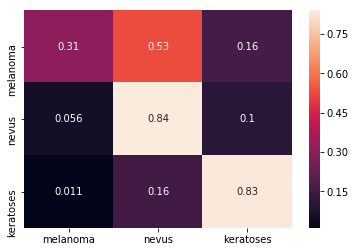

In [27]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for all classes
y_true = test_generator.classes
y_pred = [np.argmax(x) for x in predictions]

labels = ["melanoma", "nevus", "keratoses"]
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


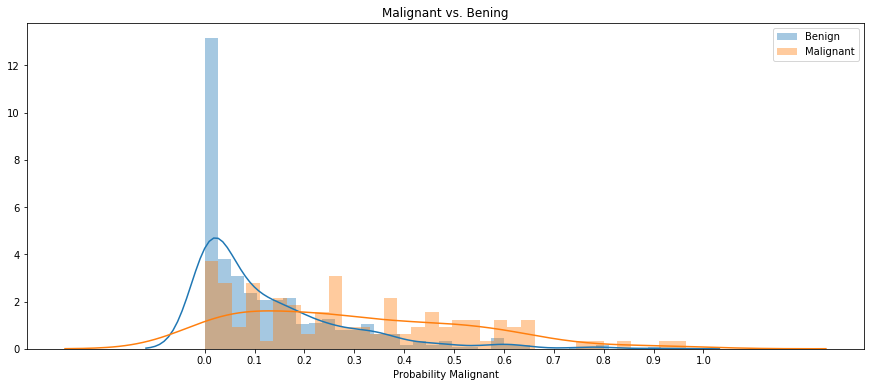

In [28]:
def plot_distribution(pred_target_y, filenames):
    melanoma_idx = []
      
    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if 'melanoma' in path.split('/'):
            melanoma_idx.append(i)
            
    bening_preds = [pred for i, pred in enumerate(pred_target_y) if i not in melanoma_idx]
    malignant_preds = [pred for i, pred in enumerate(pred_target_y) if i in melanoma_idx]
    
    fig, ax = plt.subplots(1,1,figsize=(15,6))
    
    ax.set_title('Malignant vs. Bening')
    sns.distplot(bening_preds, hist=True, kde=True, label="Benign", bins=35)
    sns.distplot(malignant_preds, hist=True, kde=True, label="Malignant", bins=35, axlabel="Probability Malignant")
    ax.legend()
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))

plot_distribution(task_1.values, test_generator.filenames)

**Insights**

We can see the a little the separation between malignant and bening lesions. This plot could be used to find the best threshold that maximizes the amount of people that have malignant lesions.
* The model predicts that about 50% of the malignant lesions are bening (Really close to 0%)
* The model predicts correctly 50% of the malignant lesions as malignant (as we can see in the confusion matrix)
* In the event that we had to choose a threshold (this is dangerous because a lot of our malignant lesions are very near the 0), we could say that a "good" threshold is around 0.05, where it identifies a lot of malignant lesions (more than 50% at least) and leaves back most benign lesions (more than 90%)